In [2]:
# TEMPORARY -- Install this if don't have already. Will add widget without requiring this later. 
# pip install ipywidgets

# Model Building

In this notebook, you will work timeseries data, starting with no other context. Your goal is use the raw data to build up to a robust model. We ask that you complete the content of this notebook linearly for the best learning experience.

### Loading the data

In [3]:
# Just run this cell. 
import numpy as np
# plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.optimize import curve_fit

Let's start by loading the data, which has been cleared of any contextual details.

In [4]:
# To do: hide all context from student view 
weekly_death_counts = pd.read_csv("Weekly_Counts_of_Deaths_by_Jurisdiction_and_Age_20240317.csv", low_memory=False)

In [5]:
# To do: hide all context from student view 

# Data cleaning, filtering dataset for US totals only
weekly_death_counts['Week Ending Date'] = pd.to_datetime(weekly_death_counts['Week Ending Date'])
us_data = weekly_death_counts[weekly_death_counts["Jurisdiction"]== "United States"]
excessdeaths = us_data[us_data["Type"]=='Predicted (weighted)']
excessdeaths = excessdeaths.groupby("Week Ending Date")['Number of Deaths'].sum().reset_index()

# Only work with pre-covid, "historical" data
end_of_2019 = pd.to_datetime('2020-01-01')
excessdeaths_2015_to_2019 = excessdeaths[excessdeaths["Week Ending Date"] < end_of_2019]

# Hide dates from students.
xdata = (excessdeaths_2015_to_2019['Week Ending Date'] - excessdeaths_2015_to_2019['Week Ending Date'].min()).dt.days
ydata = excessdeaths_2015_to_2019['Number of Deaths'].values 
xdata = np.asarray(xdata)
ydata = np.asarray(ydata)

timeseries_data = pd.DataFrame({
    'time': xdata,
    'value': ydata
})

# Download current, context-stripped data and give to students. 

In [6]:
#This is the data the students will see. 
timeseries_data

,time,value
0,0,61889.0
1,7,61273.0
2,14,58754.0
3,21,57407.0
4,28,57474.0
...,...,...
255,1785,55598.0
256,1792,57418.0
257,1799,57778.0
258,1806,57579.0


## Part 1: Model Building

In this section of the notebook, we will visualize, analyze and fit our data to a model and investigate whether our model is good. To begin, let's plot our timeseries data. 


Text(0, 0.5, 'value')

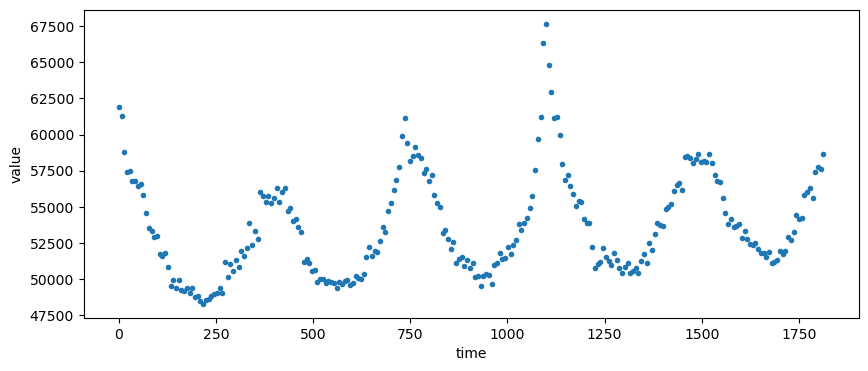

In [7]:
plt.figure(figsize=(10, 4)) 
plt.plot(xdata, ydata, '.')
plt.xlabel('time') 
plt.ylabel('value')

_Use this space to note any initial observations you have about the data._

### 1.1 A Simple Model

**Question 1.1.1**: If you had to explain what value you'd expect at any given time, how could you do it? Think about how this representation helps us understand the dataset's general behavior or trend without getting lost in the specifics of each data point.

_Use this space to share your thoughts._

We will create a constant model, that asssumes, despite the ups and downs in the data, there's an average value that represents the entire dataset reasonably well over time. 

Average value is 53625.11923076923


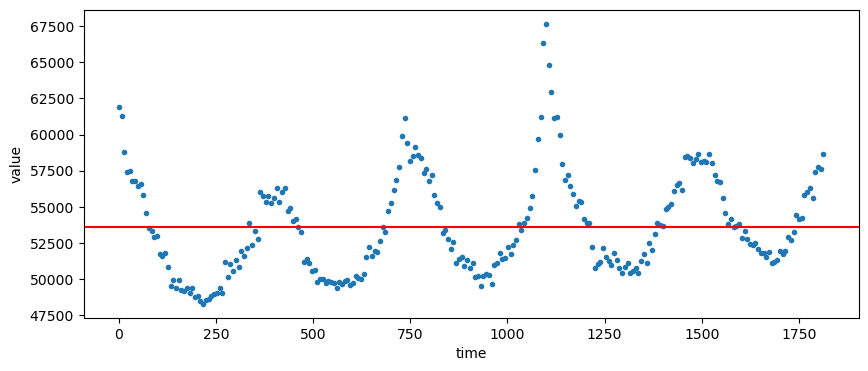

In [8]:
average_value = np.mean(ydata)
print("Average value is " + str(average_value))

plt.figure(figsize=(10, 4))
plt.plot(xdata, ydata, '.')
plt.axhline(y=average_value, color='r', linestyle='-') # Plot the constant model.
plt.xlabel('time')
plt.ylabel('value')
plt.show()

**Question 1.1.2:** In this model, how would you define the the signal? 

We can now summarize the entire dataset with a single number, giving us a baseline to compare patterns, observe deviations from the norm, and consider more parameters to build more complex models.


Developers Note: Did not include redisual plot here as the current plot is essentially the residual plot, but the mean would shifted to 0. Should we expand / include this in any way?

### 1.2 Adding More Parameters

**Question 1.2.1**: Based on the model you built above, describe what patterns and trends you notice? What mathematical function do you know that best mimics the pattern applied to the data above?

_Replace this with your answer._

One function we can use is the cosine function, a good choice when working with data that looks periodical (i.e. occurs in phases).

$$
f(x) = A \cos(B(x - C)) + D
$$

Providing initial guesses for more complex models can help guide the computational process towards a more accurate and efficient solution. Use the widget below to experiment with what you can use as your intial guesses for the parameters A, B, C, and D. Don't worry about fitting the perfect model, a rough start is to get started will be good enough for our optimizing function later!

Developer Note: Included this to provide some brief reasoning as why we are doing this step. Should I go into more detail about like local minima for a better justification or not include at all? 

In [9]:
# Avoid this, look at how false positives notebook dealt with this issue.
# pip install ipywidgets

In [10]:
# Hide this for student view. See how done on previous notebooks. 
from ipywidgets import interact, FloatSlider

def cos_function(x, A, B, C, D): #Hide this so in next questions, students have to write the code. 
    return A * np.cos(B*(x - C)) + D

def plot_cos(A=1, B=1, C=0, D=0):
    x = np.linspace(0, 1800, 200)
    y = cos_function(x, A, B, C, D)
    
    plt.figure(figsize=(10, 4))
    plt.scatter(xdata, ydata, s= 4, c='gray', alpha=0.5, label='original data')
    plt.plot(x, y, label='cosine function')
    
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Widget w/ slider inputs.
A_slider = FloatSlider(min=0, max=10000, step=1, readout_format='.0f')
B_slider = FloatSlider(min=0, max=0.2, step=0.001, readout_format='.2f')
C_slider = FloatSlider(min=-50, max=50, step=0.1, readout_format='.1f')
D_slider = FloatSlider(min=15000, max=75000, step=1, readout_format='.0f')
interact(plot_cos, A=A_slider, B=B_slider, C=C_slider, D=D_slider)

# Developer note: From playing around, aything around 4000, 0.02, 20, 54000 is a more than good enough guess for the optimize function. 

interactive(children=(FloatSlider(value=0.0, description='A', max=10000.0, readout_format='.0f', step=1.0), Fl…

<function __main__.plot_cos(A=1, B=1, C=0, D=0)>

**Question 1.2.2**: Assign the values you choose for A, B, C, and D to `guess`, in that order, as a list. 

In [19]:
# guess = [...]
guess = [4000, 0.02, 20, 54000] 

Using the values for A, B, C, and D above as our guesses, let's find the best parameters that minimize error. This may be unfamiliar, but we will leverage the scipy library to do most of the heavylifting for us. 

You'll know your guesses were good if the model is nicely fit to the data.

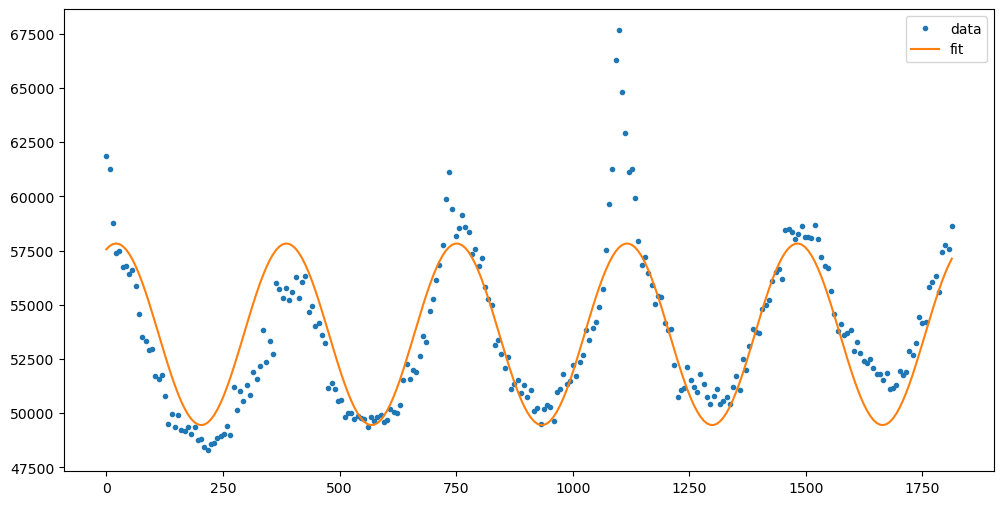

In [30]:
# Decide what students should code here, how much scaffolding should be given.

xdata = (excessdeaths_2015_to_2019['Week Ending Date'] - excessdeaths_2015_to_2019['Week Ending Date'].min()).dt.days
ydata = excessdeaths_2015_to_2019['Number of Deaths'].values 
xdata = np.asarray(xdata)
ydata = np.asarray(ydata)
plt.figure(figsize=(12, 6)) 

def cos_func(x, A, B, C, D):
    return A * np.cos(B*(x - C)) + D

parameters, covariance = curve_fit(cos_func, xdata, ydata, p0=guess)
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
fit_D = parameters[3]

fit_cosine = cos_func(xdata, fit_A, fit_B, fit_C, fit_D)

plt.plot(xdata, ydata, '.', label='data')
plt.plot(xdata, fit_cosine, '-', label='fit')

plt.legend()

Nice! Our model looks more accurate to our data now. 

### 1.3 Evaluating goodness of fit

##### TO DO
- How to motivate studunts to add complexity. Is what we have right now is a good model?
- Add some context. The data we are working with is about excess deaths and time unit (week). Define that but give no info on time period. Week 0 is some start date.
- Add 68% error bars of say +/- 100 (justify why reasonable)
- Does out model pass through roughly 68%
- If not pass then what does that tell us? What if all data passes through the error bars? How many do we expect to pass through?
- Should guide students to consider one additional paramter, adding linearity to the cosine fxn
- Plot the newest model.

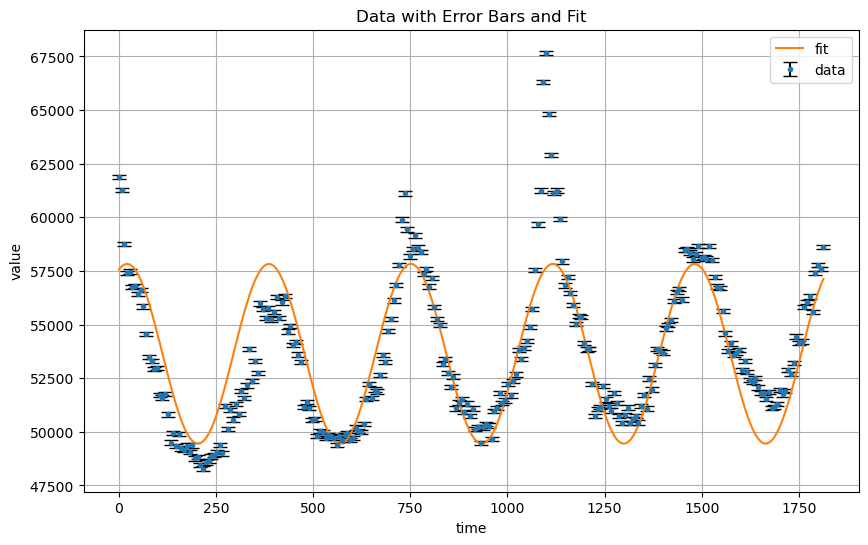

In [31]:
plt.figure(figsize=(10, 6))
plt.errorbar(xdata, ydata, yerr=100, fmt='.', label='data', ecolor='black', capsize=5)
plt.plot(xdata, fit_cosine, '-', label='fit')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.title('Data with Error Bars and Fit')
plt.grid(True)
plt.show()

## Part 2: Finding a signal

##### TO DO
- Historical model. What is acceptable SD for a given week? (Ask Winston/Aditya/Miranda about this).
- Consider anything outside those bounds to be a signal. (this is for national govt context)
- Fit model to all data (what was excluded).
- Find the first week you would signal an alarm.
- Reveal the true data --> give full context to the data


## More thought questions 
- National government ask what else could it be? How do you know this is related to COVID? -- come back to see what Winston had originally suggested in 4/1 meeting (notes lost in deleted notebook ): )
- We've been building a model as if any given year is the same, and that's not true.

Looking back now, ask student to give orders of understanding for each factor we added into the model.

## Part 3: Fermi problem (Bonus)

The physics approach of connecting to unobvious things to find the value of another. Use excess deaths rate and XYZ, to find the population rate. (usually it's just something you search up).

## Part 4: Policymaking 

Data 8 Lecture with Chief Data Scientist DJ Patil: https://data.berkeley.edu/news/dj-patil-calls-data-scientists-new-kind-first-responder

Not developed yet, would love any suggesstion/ideas if your still reading this far!

## Extra (No Context Water Levels Model)

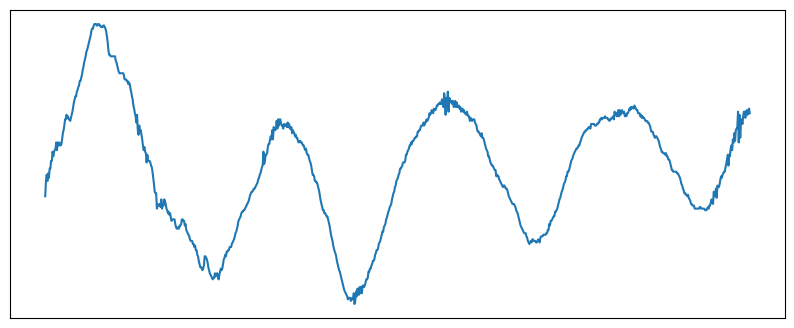

In [32]:
data = pd.read_csv("tide_data.csv")
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time (GMT)'])
data.set_index('DateTime', inplace=True)

plt.figure(figsize=(10, 4))  # Optional: Sets the figure size
plt.plot(data.index, data['Verified (ft)'])  # Plotting

plt.gca().xaxis.set_visible(False)  # Hides the x-axis values
plt.gca().yaxis.set_visible(False)  # Hides the y-axis values

_Hide: This of the observed water levels every six minutes in Dog River Bridge AL. Data source is NOAA._
https://tidesandcurrents.noaa.gov/waterlevels.html?id=8735391&units=standard&bdate=20111129&edate=20111202&timezone=GMT&datum=MLLW&interval=6&action=